## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [28]:
def display_flow_as_image(flow, img):
    h, w = flow.shape[:2]
    flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Normalize magnitude for better visualization
    flow_magnitude = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Create HSV image
    hsv_image = np.zeros((h, w, 3), dtype=np.uint8)
    hsv_image[..., 0] = flow_angle * 180 / np.pi / 2  # Hue represents direction
    hsv_image[..., 1] = 255                          # Saturation
    hsv_image[..., 2] = flow_magnitude               # Value represents magnitude

    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


    # Do wyświetlenia wektorów na obrazie
    step = 20
    y, x = np.mgrid[step // 2:h:step, step // 2:w:step].reshape(2, -1)
    y, x = y.astype(int), x.astype(int)
    fx, fy = flow[y, x].T

    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    alg_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(alg_vis, lines, isClosed=False, color=(0, 255, 0), thickness=1)

    for (x1, y1), _ in lines:
        cv2.circle(alg_vis, (x1, y1), radius=1, color=(0, 255, 0), thickness=1)

    return alg_vis, bgr_image


def calculate_and_display_optical_flow(video_path, frame_start):
    cap = cv2.VideoCapture(video_path)

    for _ in range(frame_start):
        ret, _ = cap.read()

    ret, frame1 = cap.read()
    if not ret:
        print("Could not read frame.")
        return

    ret, frame2 = cap.read()
    if not ret:
        print("Could not read second frame.")
        return

    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Farneback's algorithm
    flow = cv2.calcOpticalFlowFarneback(
    prev=gray1,
    next=gray2,
    flow=None,
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
    )

    alg_vis, flow_image = display_flow_as_image(flow, gray2)

    plt.figure(figsize=(10, 7))

    plt.subplot(2, 2, 1)
    plt.title("Frame 1")
    plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.title("Frame 2")
    plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.title("Optical Flow")
    plt.imshow(cv2.cvtColor(flow_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.title("Optical Flow")
    plt.imshow(cv2.cvtColor(alg_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    cap.release()


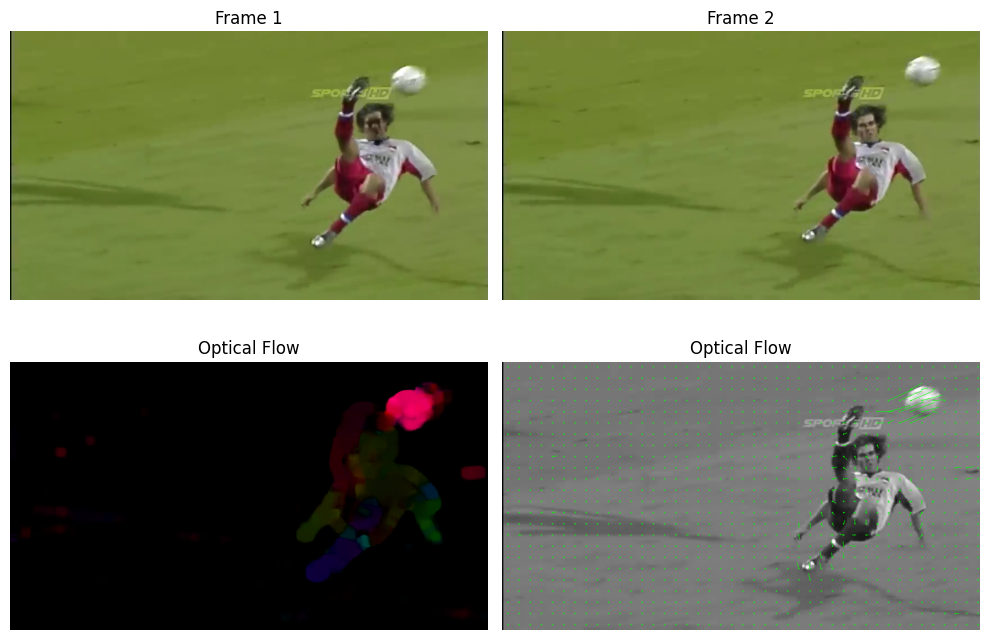

In [29]:
video_path = "dane/kick.mp4"
frame_start = 35
calculate_and_display_optical_flow(video_path, frame_start)

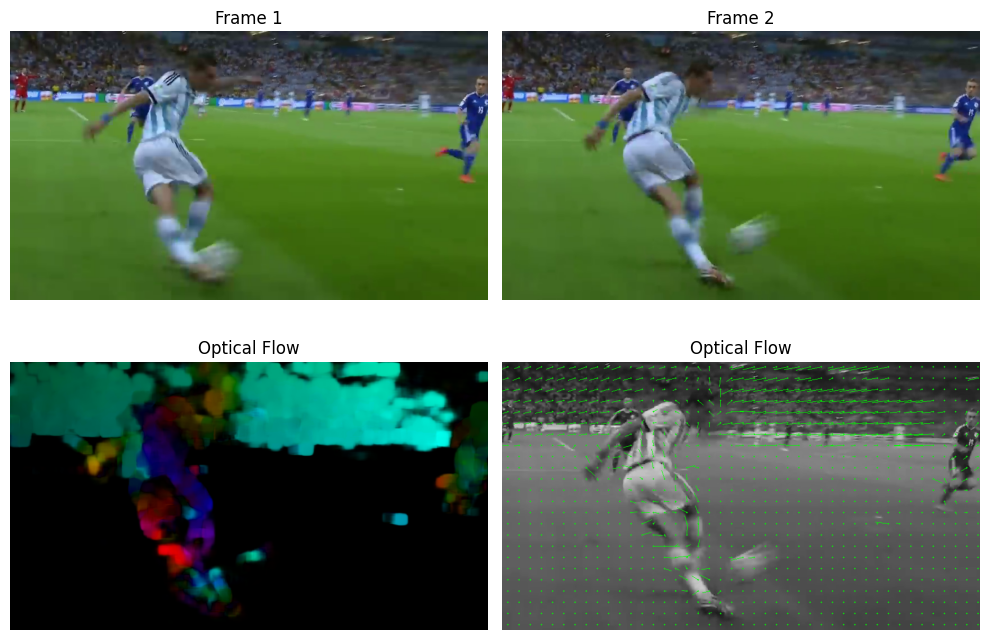

In [30]:
video_path = "dane/back.mp4"
frame_start = 29
calculate_and_display_optical_flow(video_path, frame_start)

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

In [31]:
def winsize_for_flow(video_path, frame_start, windows):
    cap = cv2.VideoCapture(video_path)

    for _ in range(frame_start):
        ret, _ = cap.read()

    ret, frame1 = cap.read()
    if not ret:
        print("Could not read frame.")
        return

    ret, frame2 = cap.read()
    if not ret:
        print("Could not read second frame.")
        return

    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(10,7))
    plt.subplot(1, 2, 1)
    plt.title("Frame 1")
    plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Frame 2")
    plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    for window in windows:

        flow = cv2.calcOpticalFlowFarneback(
        prev=gray1,
        next=gray2,
        flow=None,
        pyr_scale=0.5,
        levels=3,
        winsize=window,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
        )

        alg_vis, flow_image = display_flow_as_image(flow, gray2)

        plt.figure(figsize=(10, 7))

        plt.subplot(1, 2, 1)
        plt.title(f"Optical Flow, Winsize = {window}")
        plt.imshow(cv2.cvtColor(flow_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title(f"Optical Flow, Winsize = {window}")
        plt.imshow(cv2.cvtColor(alg_vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    cap.release()


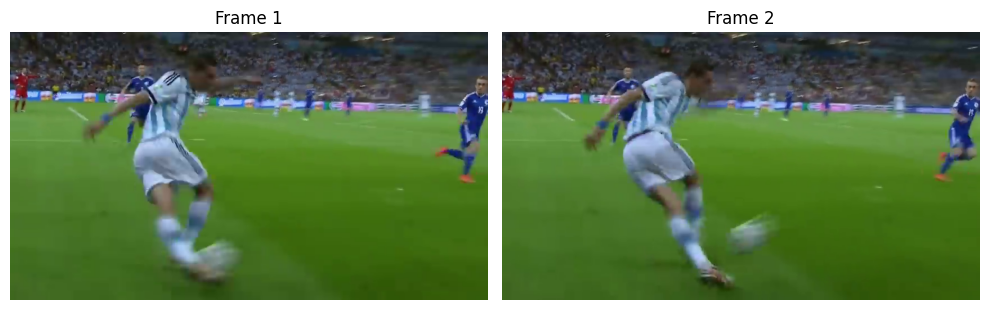

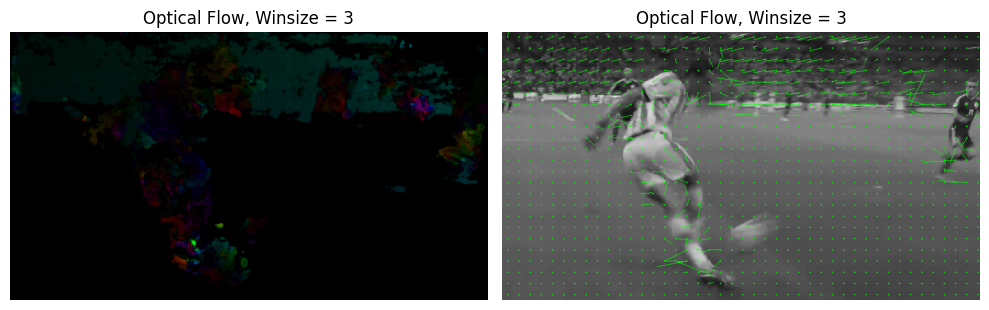

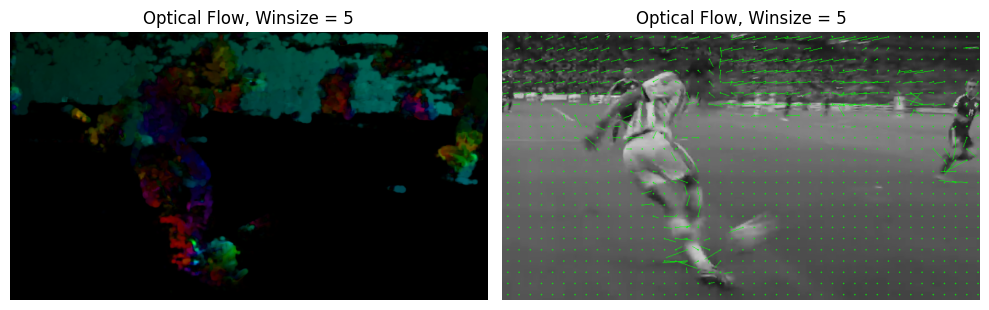

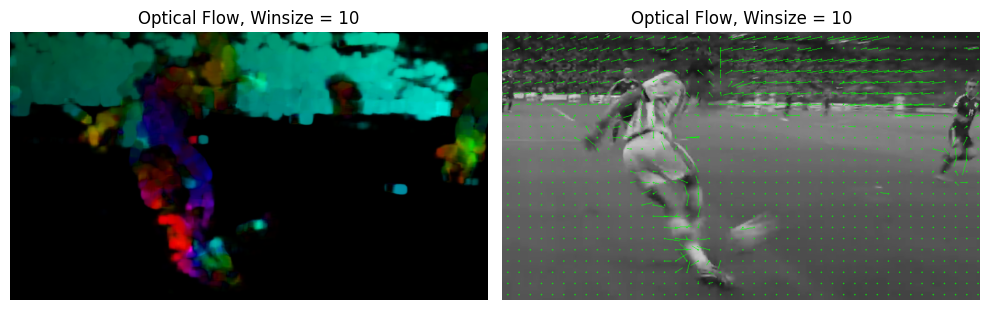

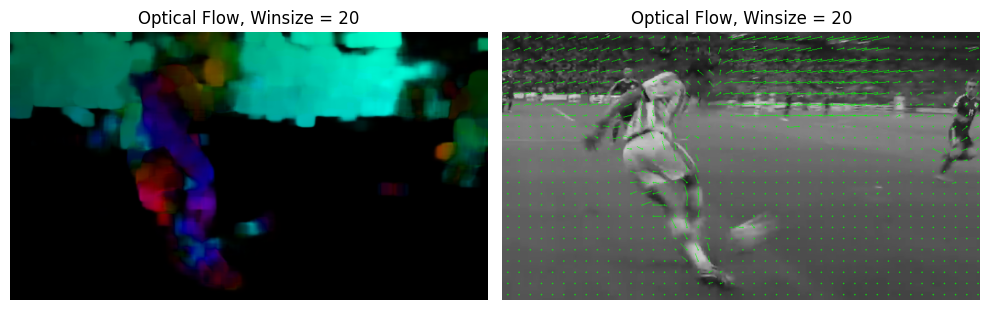

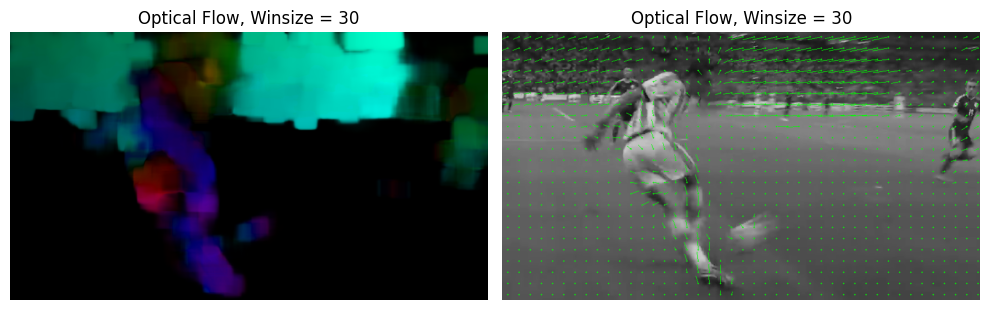

In [32]:
video_path = "dane/back.mp4"
frame_start = 29
windows = [3, 5, 10, 20, 30]
winsize_for_flow(video_path, frame_start, windows)

Komentarz 1:

- Dla małych okien wyniki mogą być zaszumione, ale możliwe jest bardziej szczegółowe wykrycie drobnych ruchów
- Dla dużych okien wyniki są bardziej uśrednione, co redukuje szum, ale możemy utracić szczegóły w mniejszych ruchach

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

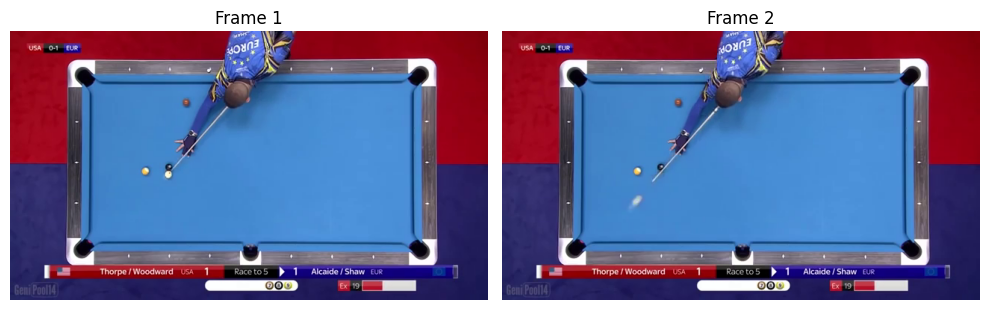

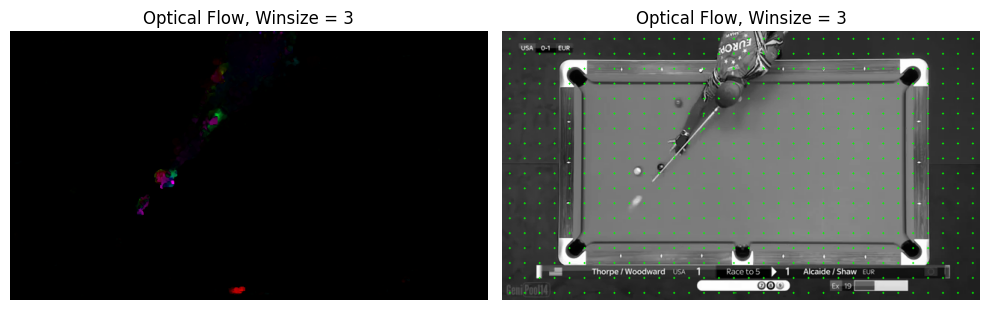

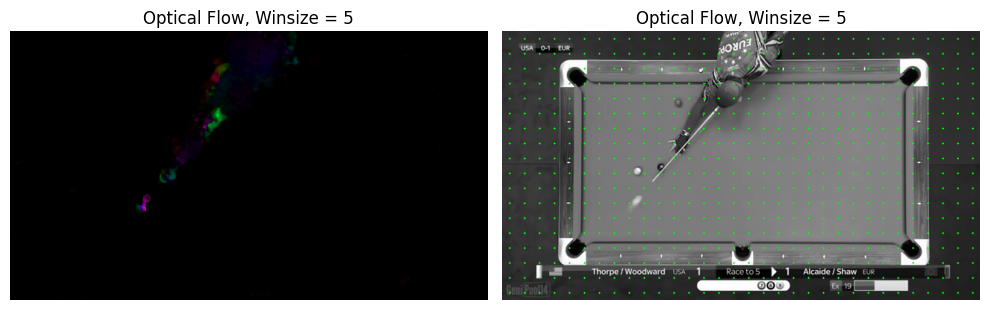

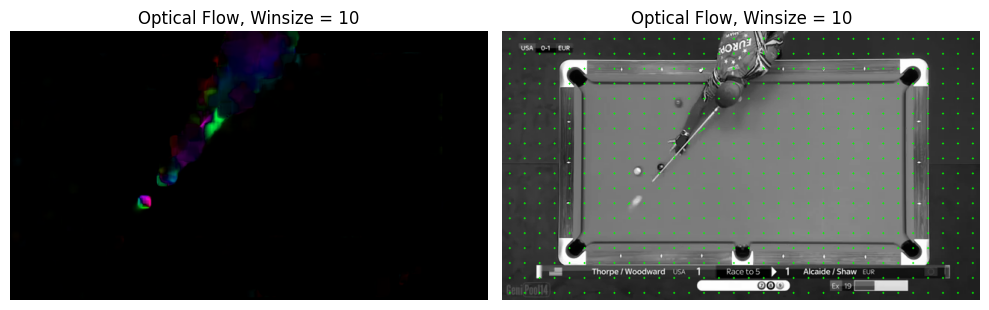

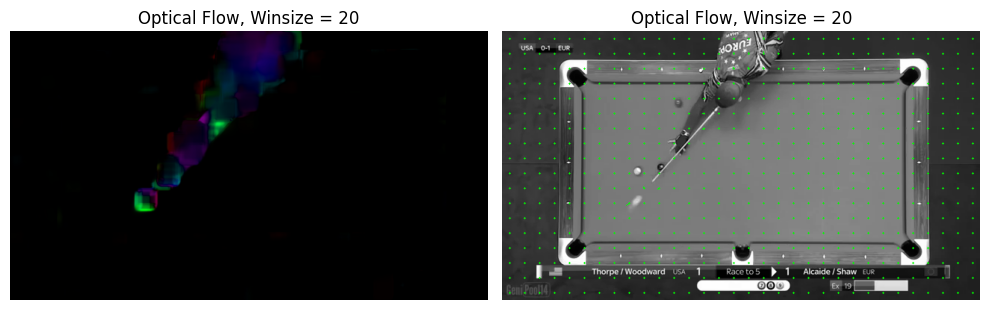

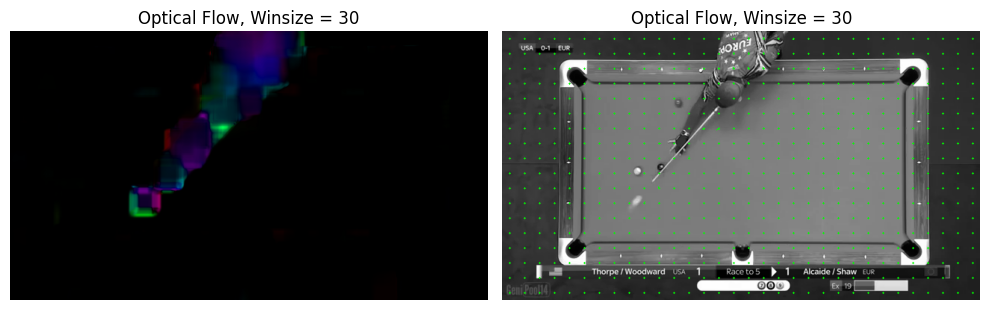

In [33]:
video_path = "dane/shot.mp4"
frame_start = 20
windows = [3, 5, 10, 20, 30]
winsize_for_flow(video_path, frame_start, windows)

Komentarz 2:

- Uzyskiwane wyniki są gorsze. Lepiej sprawdzają się w tym przypadku mniejsze okna, duże nie wyłapują ruchu bili
- Ograniczeniem może być prędkość obiektu i jego rozmycie

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).